In [1]:
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
import torch
import re
from transformers import pipeline
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


2023-10-18 19:40:11.784197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:40:12.395194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
!pip install transformers
!pip install optimum
!pip install auto-gptq
!pip install vaderSentiment

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.9 MB/s eta 0:00:00


In [2]:
df=pd.read_csv('School_Shooting_Data.csv')

In [3]:
df

,Created At,Text,Source,User Name,Location,Description,Followers Count,Quote Count,Reply Count,Retweet Count,Favorite Count
0,Tue Apr 30 23:57:07 +0000 2019,This week: \n• Baltimore: 1 dead\n• Birmingham...,"<a href=""http://twitter.com/download/iphone"" r...",Dante Vic,"Barcelona, Spain",rhythm & blues 🎶 #UNCC17,485,113,112.0,2441.0,4605.0
1,Tue Apr 30 23:29:19 +0000 2019,Two people dead and several injured at the Uni...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Shannon Watts,NaN,"Founder of @MomsDemand, grassroots army of @Ev...",310019,351,507.0,6612.0,16246.0
2,Wed May 01 00:36:25 +0000 2019,Saddened to hear about the news at UNC Charlot...,"<a href=""http://twitter.com/download/iphone"" r...",President Parker 🇺🇸,"Charlotte, NC",Excellence is the Only Standard|#NCCU19 Studen...,7440,0,0.0,44.0,85.0
3,Wed May 01 06:48:12 +0000 2019,It’s a sad reality when there’s been 106 schoo...,"<a href=""http://twitter.com/download/iphone"" r...",Mike Kelleher,"Hazlet, New Jersey",•Part time owner of salernos pizzeria. •GQ Mag...,546,0,0.0,0.0,0.0
4,Wed May 01 02:37:28 +0000 2019,I'm heartsick for the victims of the #UNCC sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Elizabeth Warren,Massachusetts,"US Senator, MA. Former teacher & law professor...",2452166,27,123.0,971.0,5327.0
...,...,...,...,...,...,...,...,...,...,...,...
12612,Wed May 01 05:06:02 +0000 2019,My prayers go to the victims and families of t...,"<a href=""http://twitter.com/download/iphone"" r...",Omar Navarro,"Los Angeles, CA",🌟 Republican Running against Maxine Waters 202...,194730,7,33.0,71.0,236.0
12613,Tue Apr 30 23:00:13 +0000 2019,As the news of #uncc breaks... this video make...,"<a href=""http://twitter.com/download/iphone"" r...",BEX {rebekah},"Boston, MA",EP & CoHost of Matty In The Morning on KISS 10...,7877,12,5.0,262.0,518.0
12614,Tue Apr 30 23:25:16 +0000 2019,you didn't have to tell me that the UNCC shoot...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Jeff Tiedrich,NaN,"Don't blame me, I voted for the email lady.",113777,92,199.0,1729.0,7725.0
12615,Wed May 01 02:33:51 +0000 2019,This is my 2¢ #UNCC https://t.co/KhGxf3FXbX,"<a href=""http://twitter.com/download/iphone"" r...",Grant Phillips,"Huntersville, NC",Class of 2019 | Pine Lake Prep Baseball #6 | O...,86,1,0.0,8.0,56.0


In [4]:
# Drop duplicates based on the 'text' column
df.drop_duplicates(subset='Text', keep='first', inplace=True)

In [5]:
df['Text'][100]

'To all of the first responders who came to our rescue today at #UNCC thank you for being so brave, for risking your… https://t.co/HGDOlgtepT'

# Text Cleaning

In [6]:
# Define a function to clean tweets
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove special characters and punctuation
    tweet = re.sub(r'[^A-Za-z0-9]+', ' ', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove extra whitespaces
    tweet = ' '.join(tweet.split())
    return tweet

# Apply the cleaning function to the 'Text' column
df['Cleaned_Text'] = df['Text'].apply(clean_tweet)

# Display the cleaned text
print(df['Cleaned_Text'])

0        this week baltimore 1 dead birmingham 4 injure...
1        two people dead and several injured at the uni...
2        saddened to hear about the news at unc charlot...
3        it s a sad reality when there s been 106 schoo...
4        i m heartsick for the victims of the uncc shoo...
                               ...                        
12598    are your kids planning a school shooting use t...
12599    it is very upsetting to learn the details abou...
12603           it s crazy how normal this has become uncc
12605    prayers to the uncc students factually and so ...
12610    breaking shots fired at unc charlotte campus s...
Name: Cleaned_Text, Length: 4961, dtype: object


# Text length Distribution

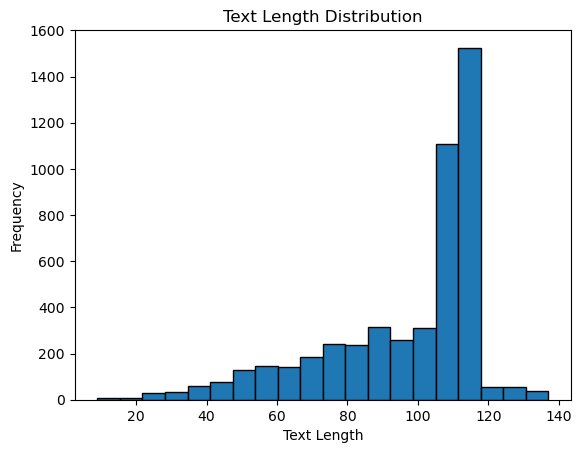

In [12]:
# Calculate text lengths and create a new column
df['Text_Length'] = df['Cleaned_Text'].apply(len)
# Create a histogram of text lengths
plt.hist(df['Text_Length'], bins=20, edgecolor='k')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

looks like most of the tweets range from 100 to 120 in length

In [67]:
df['Cleaned_Text'][0]

'this week baltimore 1 dead birmingham 4 injured nashville 7 injured west chester 4 dead uncc 2'

In [13]:
df['Created At']

0        Tue Apr 30 23:57:07 +0000 2019
1        Tue Apr 30 23:29:19 +0000 2019
2        Wed May 01 00:36:25 +0000 2019
3        Wed May 01 06:48:12 +0000 2019
4        Wed May 01 02:37:28 +0000 2019
                      ...              
12598    Fri Mar 29 20:32:42 +0000 2019
12599    Wed May 01 02:24:52 +0000 2019
12603    Wed May 01 05:28:42 +0000 2019
12605    Wed May 01 00:34:20 +0000 2019
12610    Wed May 01 05:44:51 +0000 2019
Name: Created At, Length: 4961, dtype: object

In [12]:

# Specify the device as "cuda" (GPU)
device = torch.device("cuda")

# Load the model and tokenizer on the GPU
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

# Load the VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate RoBERTA sentiment scores
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', max_length=512).to(device)
    output = model(**encoded_text)
    scores = output.logits[0].detach().cpu().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

# Create a dictionary to store results
res = {}

# Iterate through the DataFrame
for i, row in df.iterrows():
    text = row['Cleaned_Text']
    myid = i

    # Calculate VADER sentiment scores
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value

    # Calculate RoBERTA sentiment scores
    roberta_result = polarity_scores_roberta(text)

    # Merge the results
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
res[myid]

{'vader_neg': 0.414,
 'vader_neu': 0.586,
 'vader_pos': 0.0,
 'vader_compound': -0.891,
 'roberta_neg': 0.71697384,
 'roberta_neu': 0.27828202,
 'roberta_pos': 0.0047441884}

# Distribution for polarity scores for roberta and vader

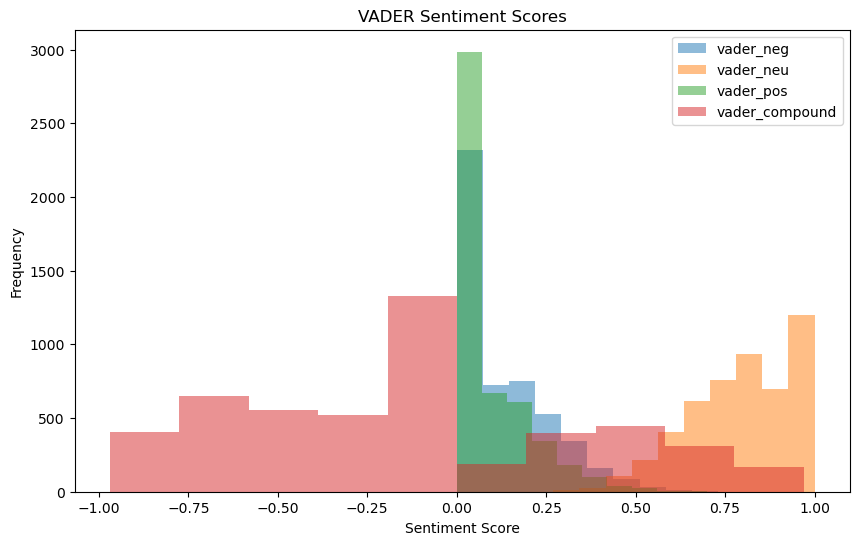

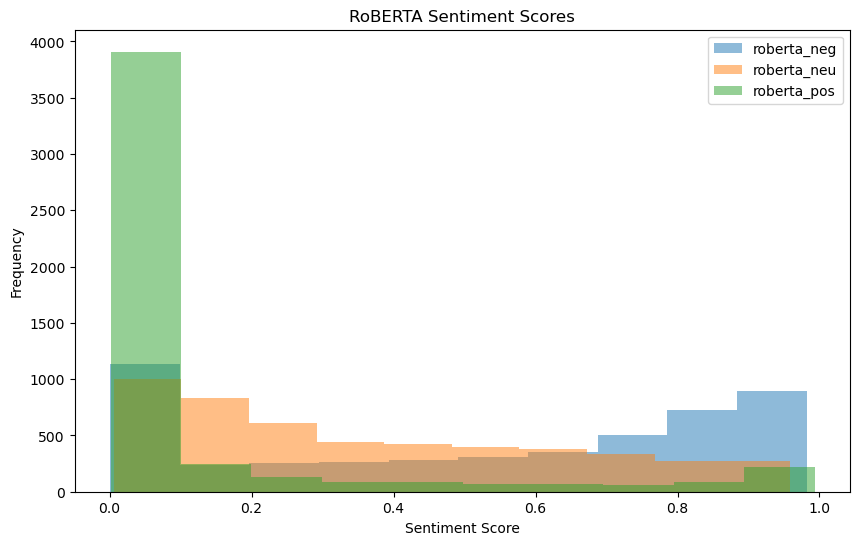

       vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg   
0          0.519      0.481      0.000         -0.9325     0.633111  \
1          0.280      0.720      0.000         -0.7906     0.905138   
2          0.145      0.855      0.000         -0.5267     0.632324   
3          0.114      0.886      0.000         -0.4767     0.948126   
4          0.098      0.769      0.132          0.2023     0.873757   
...          ...        ...        ...             ...          ...   
12598      0.000      0.830      0.170          0.5994     0.477607   
12599      0.159      0.841      0.000         -0.5256     0.963076   
12603      0.231      0.769      0.000         -0.3400     0.591215   
12605      0.000      0.504      0.496          0.9297     0.004358   
12610      0.414      0.586      0.000         -0.8910     0.716974   

       roberta_neu  roberta_pos  
0         0.355686     0.011203  
1         0.091267     0.003595  
2         0.333429     0.034247  
3         0

In [14]:

# Create a DataFrame from the results dictionary
df_results = pd.DataFrame.from_dict(res, orient='index')

# Extract columns for VADER and RoBERTA sentiment scores
vader_columns = [col for col in df_results.columns if col.startswith("vader_")]
roberta_columns = [col for col in df_results.columns if col.startswith("roberta_")]

# Plot the sentiment scores from VADER
plt.figure(figsize=(10, 6))
plt.title("VADER Sentiment Scores")
for col in vader_columns:
    plt.hist(df_results[col], alpha=0.5, label=col)

plt.legend()
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Plot the sentiment scores from RoBERTA
plt.figure(figsize=(10, 6))
plt.title("RoBERTA Sentiment Scores")
for col in roberta_columns:
    plt.hist(df_results[col], alpha=0.5, label=col)

plt.legend()
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# You can also display the DataFrame for a side-by-side comparison
print(df_results)

# UNCC incident effect on public sentiment

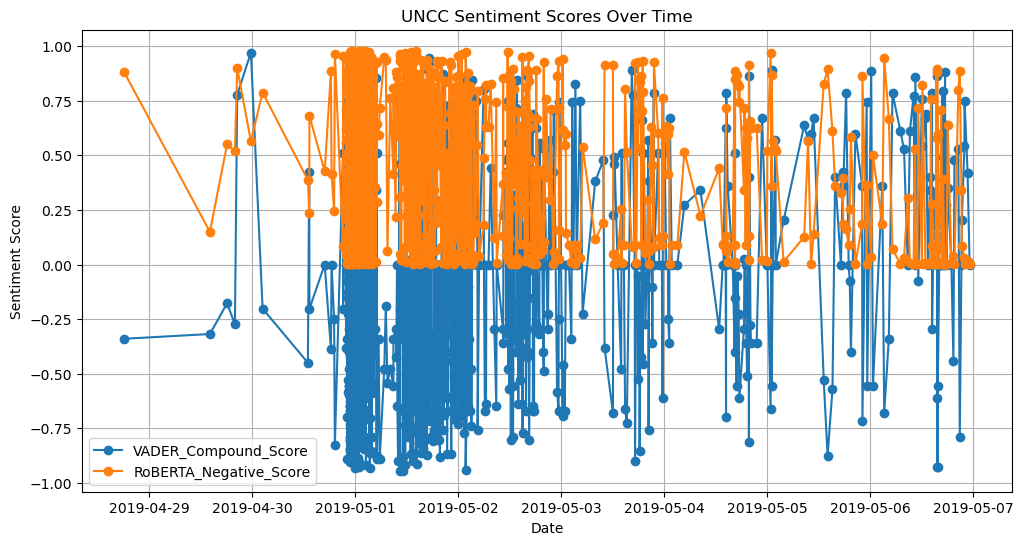

In [38]:
# Add the sentiment scores to your DataFrame
df['VADER_score'] = [res[i]['vader_compound'] for i in res]
df['RoBERTA_score'] = [res[i]['roberta_neg'] for i in res]  # You can use the desired RoBERTA score

# Convert 'created_at' column to datetime
df['Created At'] = pd.to_datetime(df['Created At'], format='%a %b %d %H:%M:%S +0000 %Y')

start_date = pd.to_datetime('2019-04-27')# Adjust the date as needed
end_date = pd.to_datetime('2019-05-07')
df1 = df[(df['Created At'] >= start_date) & (df['Created At'] <= end_date)]
# Group by date and calculate the mean sentiment score for each date
grouped = df1.groupby('Created At').agg({'VADER_score': 'mean', 'RoBERTA_score': 'mean'})

# Plot the sentiment scores over time
plt.figure(figsize=(12, 6))
plt.title("UNCC Sentiment Scores Over Time")
plt.plot(grouped.index, grouped['VADER_score'], label='VADER_Compound_Score', marker='o')
plt.plot(grouped.index, grouped['RoBERTA_score'], label='RoBERTA_Negative_Score', marker='o')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.show()

# STEM Incident effect on public sentiment

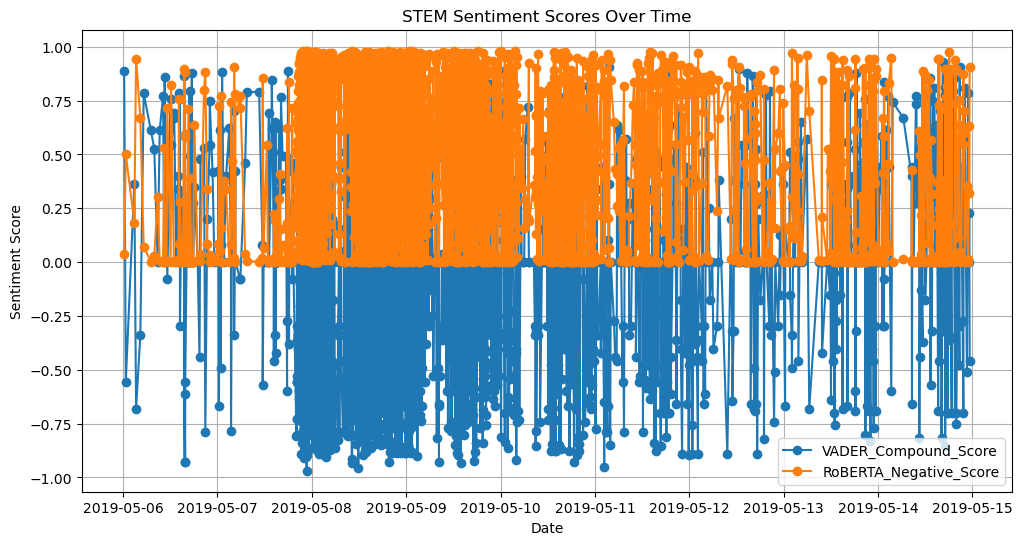

In [37]:
start_date = pd.to_datetime('2019-05-06')# Adjust the date as needed
end_date = pd.to_datetime('2019-05-15')
df1 = df[(df['Created At'] >= start_date) & (df['Created At'] <= end_date)]
# Group by date and calculate the mean sentiment score for each date
grouped = df1.groupby('Created At').agg({'VADER_score': 'mean', 'RoBERTA_score': 'mean'})

# Plot the sentiment scores over time
plt.figure(figsize=(12, 6))
plt.title("STEM Sentiment Scores Over Time")
plt.plot(grouped.index, grouped['VADER_score'], label='VADER_Compound_Score', marker='o')
plt.plot(grouped.index, grouped['RoBERTA_score'], label='RoBERTA_Negative_Score', marker='o')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.show()